<a href="https://colab.research.google.com/github/abiabraham83/Match-Filtering-vs-CNN-/blob/main/CNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow #Machine learning tool

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q nnAudio # This allows the timeseries data to cobverteed into a image(spectrogram)

     |████████████████████████████████| 43 kB 1.2 MB/s 


In [ ]:
!pip install -U efficientnet #pre-trained model on a massive image database 

In [ ]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import sem

#Machine learning tool

import keras
import tensorflow 
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GlobalAveragePooling2D, Convolution2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image

from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

import torch
from nnAudio.Spectrogram import CQT1992v2
import efficientnet.tfkeras as efn

In [ ]:
!unzip drive/My\ Drive/Kaggle\ Dataset/train.zip #extracts the compresses file within  colab

In [ ]:
# I am using concepts and certain codes used by Mrigendra Agrwal from Kaggle.
#Reference https://www.kaggle.com/code/mrigendraagrawal/tf-g2net-eda-and-starter

In [ ]:
#Read in the training labels csv and assign paths
training_labels = pd.read_csv('/content/drive/My Drive/Kaggle Dataset/training_labels.csv')

path = list(training_labels['id'])
for i in range(len(path)):
    path[i] = '/content/drive/My Drive/Kaggle Dataset/training_labels.csv' + path[i][0] +  '/' + path[i][1] +  '/' + path[i][2] +  '/' + path[i] + '.npy'

In [ ]:
#Function to set a path to call in the data
def path2id(idx,is_train = True):
    path = '/content/'
    if is_train:
        path +=  idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    else:
        path +=  idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    return path

In [ ]:
#function to plot time series of each detector and for a q-scan.
def increase_dimension(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): 
    
    waves = np.load(path2id(idx,is_train)) #loads the data 
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves) # converts into an image
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

In [ ]:
#Dataset Generator 
class Dataset(Sequence):
    
    def __init__(self,idx,y=None,batch_size=32, shuffle= True):
        self.idx = idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train=True
        else:
            self.is_train=False
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    def __getitem__(self,ids):
        batch_ids = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([increase_dimension(x,self.is_train) for x in batch_ids])
        batch_X = np.stack(list_x)
        
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))
    
    def debug(self):
        return self.idx

In [ ]:
#Reducing the size of dataset 
train_data_size = len(training_labels['id'].values)//8 #reducing the data size to 70,000 
train_idx = training_labels['id'].values[0:train_data_size]
valid_idx = training_labels['target'].values[0:train_data_size]
test_idx =  training_labels['id'].values[70000:140000] 

In [ ]:
print(len(train_idx))
print(len(test_idx))

In [ ]:
#Spliting the dataset in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(train_idx,valid_idx,test_size=0.05, random_state=None, stratify=valid_idx)

In [ ]:
#Applying the dataset generator to train, test and validation sets
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_test, y_test)
test_dataset  = Dataset(test_idx)
len(y_train)

In [ ]:
#Building the CNN model
#input shape decided from examples and trial and wrror. 
model = Sequential([keras.layers.InputLayer(input_shape=(27,128,1)), Convolution2D(3,3,activation='relu',padding='same'), 
                   efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
                   GlobalAveragePooling2D(),
                   Dense(256,activation='relu'),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'), 
                   Dense(1,activation='sigmoid')])

model.summary()
model.compile(optimizer= Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=["accuracy"]) # loss is binary_crossentropy, this is for binary classification. 

16818176/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 128, 3)        30        
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                         

In [ ]:
#Training the model
model.fit(train_dataset, validation_data=valid_dataset, use_multiprocessing=True,
          epochs = 3) 

In [ ]:
model.save('Project/Model')

In [ ]:
loaded_model_v2 = keras.models.load_model('Project/Model')

In [14]:
df = pd.DataFrame(list()) 
df.to_csv('preds.csv')
preds = pd.read_csv('preds.csv')

In [ ]:
#Model predicting the using the test sets
model_pred = loaded_model_v2.predict(test_dataset, use_multiprocessing=True,verbose=1)
model_pred = model_pred.reshape(-1)

In [ ]:
print(len(training_labels))
print(len(train_idx))
print(len(model_pred))

In [17]:
train_data_size2 = len(y_train)
test_idx2 = training_labels['id'].values[70000:140000]

targets_s = training_labels['target']
tar_len = (len(targets_s)//5) 
targets = training_labels['target'].values[70000:140000]
print(len(targets))

70000


In [ ]:
print(model_pred)
print(len(model_pred))

In [ ]:
model_target = np.array(model_pred)
model_target[:,] = model_target[:,]>0.64 # setting threshold to create a binary classification
model_targets = model_target.astype(int)
print(model_targets)
print(len(targets)) 
    

[0 0 0 ... 0 0 0]
70000


In [ ]:
#To find the best threshold
threshs = np.linspace(0,1,10000)

max_icv = 0

for th in threshs:

    icv = preds['Model Predictions'] > th
    curr_th = sum(icv == preds['Actual Targets']) / len(preds)
    if curr_th > max_icv:
        max_icv = curr_th
        max_th = th
print(max_icv, max_th)

In [ ]:
#Converting the model predicition to 1 and 0s considering the threshold
target_frac = []
mod_tar = list(model_targets)
act_tar = list(targets)

for i in range(len(mod_tar)):
    if mod_tar[i] == act_tar[i]:
        target_frac.append(1)
    else: 
        target_frac.append(0)


    


In [ ]:
preds = pd.DataFrame({'id':test_idx2,'Model Predictions':model_pred, 
                      'Model Targets':model_targets,
                      'Actual Targets' : targets,
                      'Classified Targets': target_frac})

preds.to_csv('preds.csv',index = False)

In [ ]:
preds.head(5)

,id,Model Predictions,Model Targets,Actual Targets,Classified Targets
0,1fca0e9a1f,0.238293,0,0,1
1,1fca0fe3b6,0.358224,0,0,1
2,1fca129128,0.230218,0,1,0
3,1fca20e9d0,0.225951,0,0,1
4,1fca2327df,0.347042,0,0,1


In [40]:
predsv2 = pd.read_csv('/content/drive/MyDrive/Project /preds.csv')
predsv2.head()

,id,Model Predictions,Model Targets,Actual Targets,Classified Targets
0,1fca0e9a1f,0.238293,0,0,1
1,1fca0fe3b6,0.358224,0,0,1
2,1fca129128,0.230218,0,1,0
3,1fca20e9d0,0.225951,0,0,1
4,1fca2327df,0.347042,0,0,1


In [41]:
mod_tar2 = list(predsv2.iloc[:,2])
act_tar2 = list(predsv2.iloc[:,3])

In [ ]:
num_ones = np.count_nonzero(target_frac)
acc_score = (num_ones/len(target_frac))*100
error_score = (100-acc_score)
print('Classfied Correctly: ', acc_score, 'Classfied Incorrectly: ', error_score)


In [44]:
cm = confusion_matrix(act_tar2,mod_tar2) #Computes a confusion matrix 

TN, FP, FN, TP = confusion_matrix(act_tar2,mod_tar2).ravel()

print('True Positive(TP) = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN) = ', TN)
print('False Negative(FN) = ', FN)

accuracy = (TP + TN)/(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP) =  23073
False Positive(FP) =  3969
True Negative(TN) =  31115
False Negative(FN) =  11843
Accuracy of the binary classification = 0.774


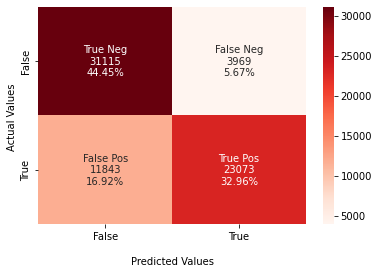

In [45]:
group_names = ['True Neg','False Neg','False Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
#plt.show()
cm_CNN_opt = plt.gcf()

In [47]:
cm_CNN_opt.savefig("cm_CNN_opt.pdf",format="pdf", bbox_inches ='tight')